# 004.004 EDA - Shots

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import ptitprince as pt

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import extend_cols, diagnose_discrete_fit
# from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

fn = '2007-2008__2017-2018.csv'
EDA_FP = PROJECT_DIR / 'data' / 'sample' / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

## Load Sample Data

Sample Data: Bundesliga Seasons 2007-2008 to 2014-2015

In [3]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date'])
df_orig = df_orig[~df_orig['season'].isin(['2015-2016', '2016-2017', '2017-2018'])]
cols = ['season', 'date', 'h', 'a', 'h_ftGoals', 'a_ftGoals', 'result', 'h_shots', 'a_shots']

df_orig = df_orig[cols].sort_values(by=['date', 'h', 'a']).reset_index(drop=True).sort_values(by=['date'])
df_orig.head(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result,h_shots,a_shots
0,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,draw,16,10
1,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,hwin,27,6


In [2]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
cols = ['']
df_orig = df_orig[cols]
df_orig.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,result
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16,10,7,4,draw
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27,6,13,0,hwin
2,germany,bundesliga,2007-2008,2007-08-11,bochum,sv-werder-bremen,2.0,2.0,17,20,4,9,draw
3,germany,bundesliga,2007-2008,2007-08-11,eintracht-frankfurt,hertha-berlin,1.0,0.0,19,10,5,3,hwin
4,germany,bundesliga,2007-2008,2007-08-11,hannover,hamburger-sv,0.0,1.0,10,14,2,8,awin


In [3]:
df_orig.tail()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,result
913,germany,bundesliga,2009-2010,2010-05-08,mainz,schalke,0.0,0.0,12,10,4,3,draw
914,germany,bundesliga,2009-2010,2010-05-08,nurnberg,fc-koln,1.0,0.0,13,5,3,2,hwin
915,germany,bundesliga,2009-2010,2010-05-08,sc-freiburg,dortmund,3.0,1.0,14,11,3,5,hwin
916,germany,bundesliga,2009-2010,2010-05-08,sv-werder-bremen,hamburger-sv,1.0,1.0,22,15,8,4,draw
917,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16,19,7,3,hwin


In [12]:
df = df_orig.copy(deep=True)
h_shots = df['h_shots'].dropna().astype('int')
a_shots = df['a_shots'].dropna().astype('int')

h_shots_mean = df['h_shots'].mean()
a_shots_mean = df['a_shots'].mean()

h_shots_median = df['h_shots'].median()
a_shots_median = df['a_shots'].median()

h_shots_var = df['h_shots'].var()
a_shots_var = df['a_shots'].var()

print(f'Home Shots:\nMean:\t\t{h_shots_mean}\nMedian:\t\t{h_shots_median}\nVariance:\t{h_shots_var}')
print(f'Away Shots:\nMean:\t\t{a_shots_mean}\nMedian:\t\t{a_shots_median}\nVariance:\t{a_shots_var}')

Home Shots:
Mean:		14.636437908496733
Median:		14.0
Variance:	26.491389349637146
Away Shots:
Mean:		11.80718954248366
Median:		11.0
Variance:	21.792804848407968


In [6]:
# Need to deal with any shot value that has no occurrences in any game
# eg 2 games have 5 shots | 0 games have 6 shots | 1 game has 7 shots
# !! Important to do this every freq count
max_shots = int(df[['h_shots', 'a_shots']].max().max())
h_shots_val_counts = h_shots.value_counts()
h_shots_dist = h_shots.value_counts().sort_index(). \
                    reindex(range(max_shots+1), fill_value=0)
a_shots_val_counts = a_shots.value_counts()
a_shots_dist = a_shots.value_counts().sort_index(). \
                    reindex(range(max_shots+1), fill_value=0)    

shots_dists = pd.concat([h_shots_dist, a_shots_dist], axis=1)

print(f'Home and Away Shots Distributions:\n\n{shots_dists}\n')

Home and Away Shots Distributions:

    h_shots  a_shots
0         0        1
1         0        3
2         2       13
3         3       33
4        12       55
5        34       71
6        43      109
7        68      160
8        96      169
9       120      191
10      154      216
11      165      235
12      187      196
13      212      181
14      194      168
15      168      143
16      181      122
17      156      106
18      139       68
19      117       64
20       86       37
21       63       21
22       64       35
23       48       20
24       38       10
25       33        6
26       17        5
27       14        6
28        7        2
29        4        0
30        8        0
31        4        0
32        6        0
33        0        2
34        2        0
35        3        0



In [7]:
shots_dists_freqs = shots_dists.copy(deep=True)
shots_dists_freqs['h_shots'] = shots_dists_freqs['h_shots'] / shots_dists['h_shots'].sum()
shots_dists_freqs['a_shots'] = shots_dists_freqs['a_shots'] / shots_dists['a_shots'].sum()
shots_dists_freqs.head()

,h_shots,a_shots
0,0.000000,0.000408
1,0.000000,0.001225
2,0.000817,0.005310
3,0.001225,0.013480
4,0.004902,0.022467


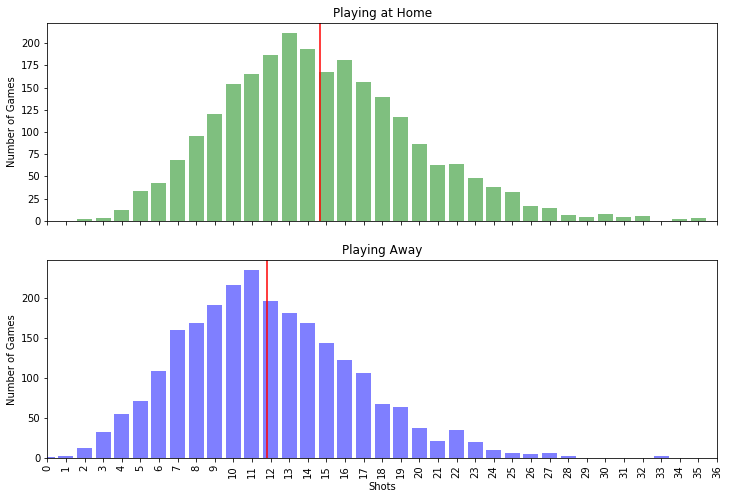

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,figsize=(12,8), sharex=True)

ax1.bar(shots_dists.index, shots_dists['h_shots'], color='g', alpha=0.5, label='Home Shots')
ax1.axvline(h_shots_mean, color='r')
ax1.set_title('Playing at Home')
ax1.set_ylabel('Number of Games')

ax2.bar(shots_dists.index, shots_dists['a_shots'], color='b', alpha=0.5, label='Away Shots')
ax2.axvline(a_shots_mean, color='r')
ax2.set_title('Playing Away')
ax2.set_ylabel('Number of Games')
ax2.set_xlabel('Shots')
ax2.set_xlim(0, len(shots_dists))

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=90)

plt.show();

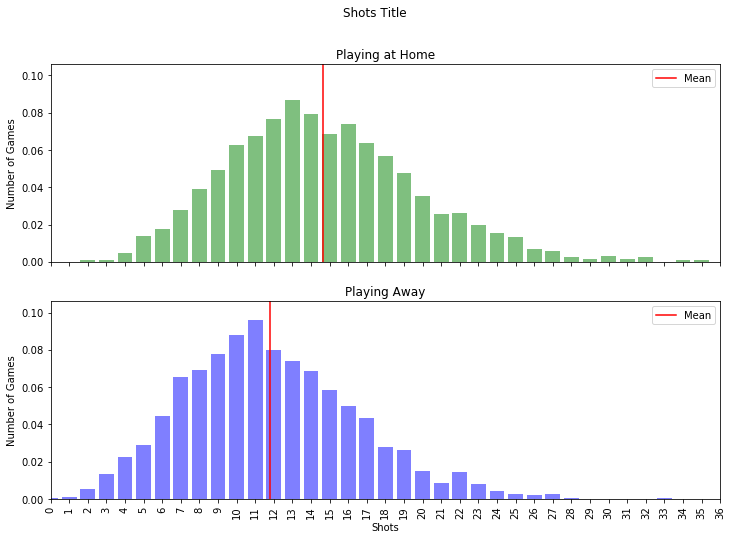

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,figsize=(12,8), sharex=True)

ax1.bar(shots_dists.index, shots_dists_freqs['h_shots'], color='g', alpha=0.5)
ax1.axvline(h_shots_mean, color='r', label='Mean')
ax1.set_title('Playing at Home')
ax1.set_ylabel('Number of Games')
max_ylim = shots_dists_freqs.max(axis=0).max()+0.01
ax1.set_ylim(0, max_ylim)
ax1.legend()

ax2.bar(shots_dists.index, shots_dists_freqs['a_shots'], color='b', alpha=0.5)
ax2.axvline(a_shots_mean, color='r', label='Mean')
ax2.set_title('Playing Away')
ax2.set_ylabel('Number of Games')
ax2.set_xlabel('Shots')
ax2.set_xlim(0, len(shots_dists))
ax2.set_ylim(0, max_ylim)
ax2.legend()

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=90)
plt.suptitle('Shots Title goes here')

plt.show();

### Fitting Shots >Distribution

Thoughts?

The distributions seem to have different locations with Home Field Advantage showing up.

I wonder what this means. Are away teams attacking less, or home teams doing a better job of defending, or a bit of both?

Both distributions seem to have a long right tail. Why is this? Is this particular teams consistently showing in this tail? Why would there be a spike at 23 shots. Is this a natural variation or some artefact of data collection?

Neither distribution seems to be truncated by the natural limit of 0 on the left.

These distributions look pretty spiky.

Maybe there are a lot of distributions with different locations - possibly for each team 

Are there certain teams that have consistently high shots? - Try a Boxplot by Team

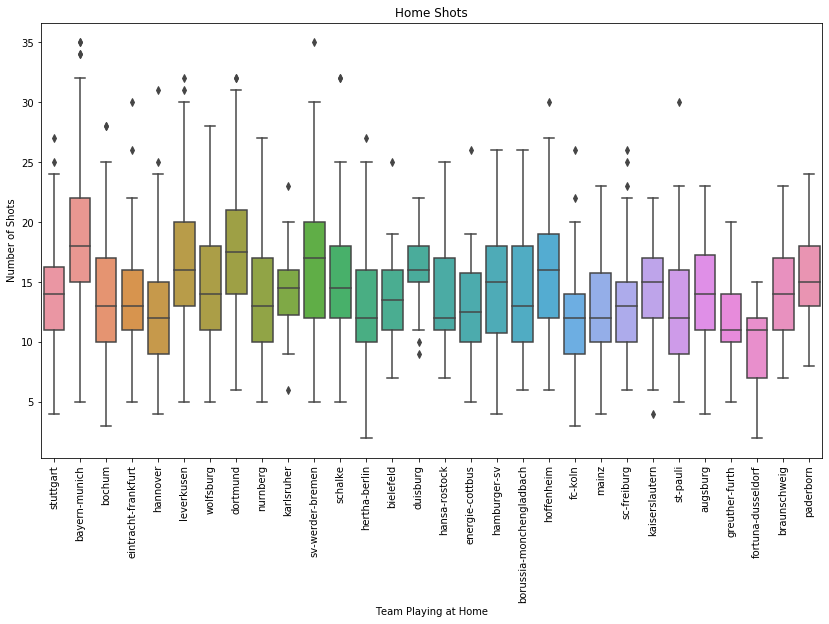

In [13]:
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

sns.boxplot(x=df["h"], y=df["h_shots"], data=df, ax=ax1)

ax1.set_title('Home Shots')
ax1.set_ylabel('Number of Shots')
ax1.set_xlabel("Team Playing at Home")
plt.xticks(rotation=90)

plt.show();

There is a lot of variation between teams with Tottenham, Liverpool, Reading, and Stoke showing the extremes.

Liverpool seem to have, on average, twice as many shots as Reading and Stoke

Try looking at individual teams distributions

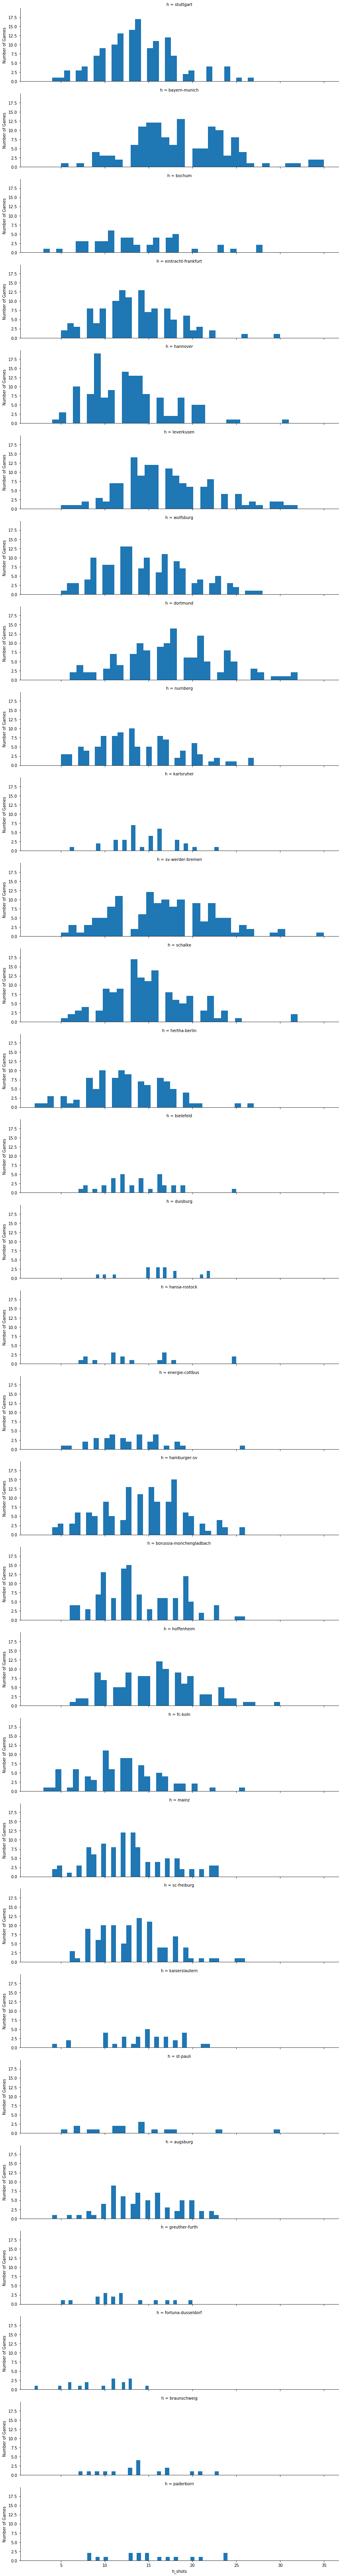

In [14]:
# Reset matplotlib style
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(inline_rc)

bins=34
g = sns.FacetGrid(df, row="h", aspect=4.0 , sharex=True)
g.map(plt.hist, "h_shots", bins=bins);
for ind, _ in enumerate(g.axes):
    g.axes[ind,0].set_ylabel('Number of Games')
plt.tight_layout()
plt.show();

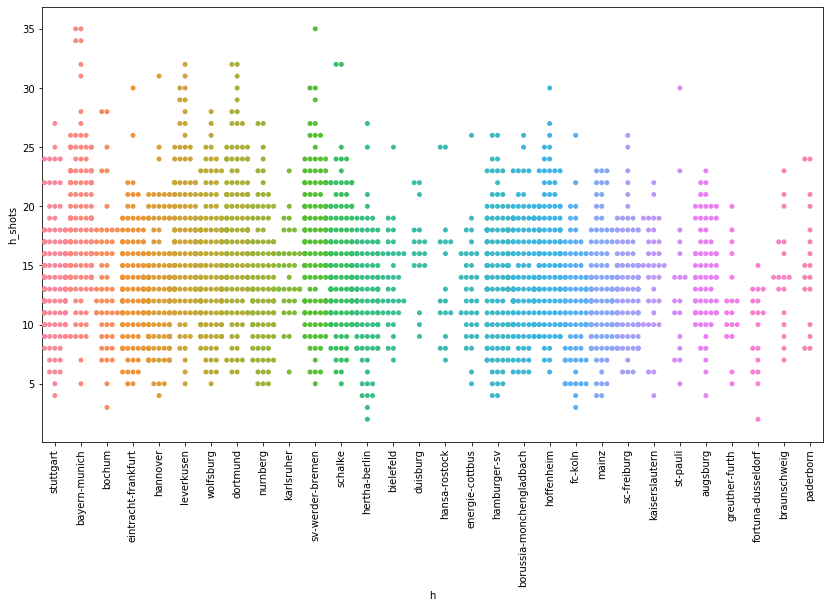

In [15]:
# plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

sns.swarmplot(x=df["h"], y=df["h_shots"], data=df, ax=ax1)

# ax1.set_title('Shots')
# ax1.set_ylabel('Number of Shots')
# ax1.set_xlabel("Team Playing at Home")
# plt.xticks(rotation=90)


# # Draw a nested boxplot to show bills by day and time
# sns.boxplot(x=df['h'], y=df['h_shots'],
#             hue=df['h'], palette=["m", "g"],
#             data=df)
# sns.despine(offset=10, trim=True)

plt.xticks(rotation=90)
plt.show();

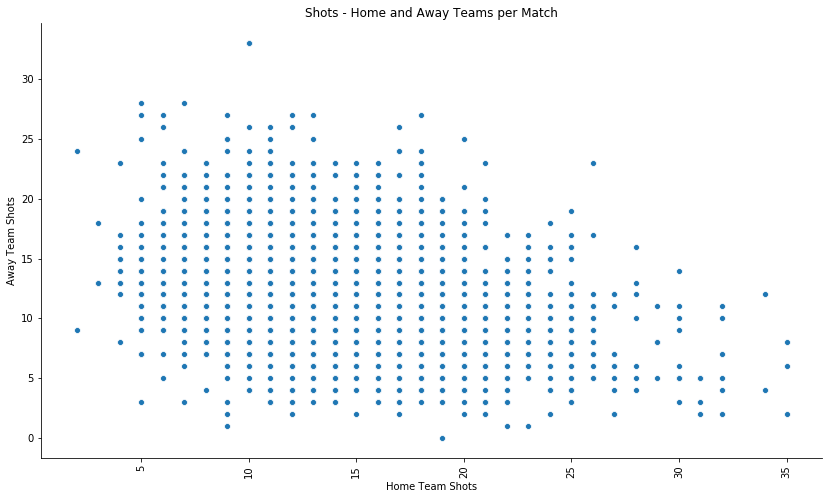

In [16]:
# plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
#sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x=df['h_shots'], y=df['a_shots'],
               # size = df['a'], sizes=(5,500),

                data=df, ax=ax1)

ax1.set_title('Shots - Home and Away Teams per Match')
ax1.set_ylabel('Away Team Shots')
ax1.set_xlabel("Home Team Shots")
plt.xticks(rotation=90)

#sns.swarmplot(df['h_goals'], df['h_shots'])#'species', 'sepal_length', data=iris)
sns.despine()

plt.show();

In [17]:
# Approxiamte to a Normal Distribution andf Fit QQ Plot
# Approximate to a Negative Binomial and review Rootogram

In [18]:
# https://github.com/gokceneraslan/fit_nbinom/blob/master/fit_nbinom.py
#!/usr/bin/env python

## fit_nbinom
# Copyright (C) 2014 Gokcen Eraslan
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

import numpy as np
from scipy.special import gammaln
from scipy.special import psi, factorial
from scipy.optimize import fmin_l_bfgs_b as optim

#import sys


# X is a numpy array representing the data
# initial params is a numpy array representing the initial values of
# size and prob parameters
def fit_nbinom(X, initial_params=None):
    infinitesimal = np.finfo(np.float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result

    def log_likelihood_deriv(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        pderiv = (N*r)/p - np.sum(X)/(1-(p if p < 1 else 1-infinitesimal))
        rderiv = np.sum(psi(X + r)) \
            - N*psi(r) \
            + N*np.log(p)

        return np.array([-rderiv, -pderiv])

    if initial_params is None:
        #reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m**2)/(v-m) if v > m else 10

        #convert mu/size parameterization to prob/size
        p0 = size / ((size+m) if size+m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     #fprime=log_likelihood_deriv,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'size': params[0], 'prob': params[1]}

In [19]:
# Fit the negative binomial to estimate the parameters
param_dict = fit_nbinom(df['h_shots'])
print(param_dict)

{'size': 18.087193770692096, 'prob': 0.5527199956355586}


In [20]:
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
mean, var, skew, kurt = stats.nbinom.stats(param_dict['size'], param_dict['prob'], moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_shots_mean:\t{h_shots_mean}\th_shots_var:\t{h_shots_var}')

mean:		14.636778427733788	variance:	26.48136225088678
h_shots_mean:	14.636437908496733	h_shots_var:	26.491389349637146


In [21]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(shots_dists.index, param_dict['size'], param_dict['prob'])

exp = norm_exp * shots_dists['h_shots'].sum()
h_shots_nbinom = pd.DataFrame(np.vstack([shots_dists['h_shots'].values, exp, norm_exp])).T
h_shots_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_shots_nbinom['obs_norm'] = h_shots_nbinom['obs']/ h_shots_nbinom['obs'].sum()
h_shots_nbinom

,obs,exp,exp_norm,obs_norm
0,0.0,0.053883,0.000022,0.000000
1,0.0,0.435917,0.000178,0.000000
2,2.0,1.860779,0.000760,0.000817
3,3.0,5.572786,0.002276,0.001225
4,12.0,13.140463,0.005368,0.004902
5,34.0,25.963347,0.010606,0.013889
6,43.0,44.684826,0.018254,0.017565
7,68.0,68.774543,0.028094,0.027778
8,96.0,96.464895,0.039406,0.039216
9,120.0,125.064380,0.051088,0.049020


In [22]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_shots_nbinom['obs'],
                              f_exp=h_shots_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=32.10085468736687, pvalue=0.5609592787621267)



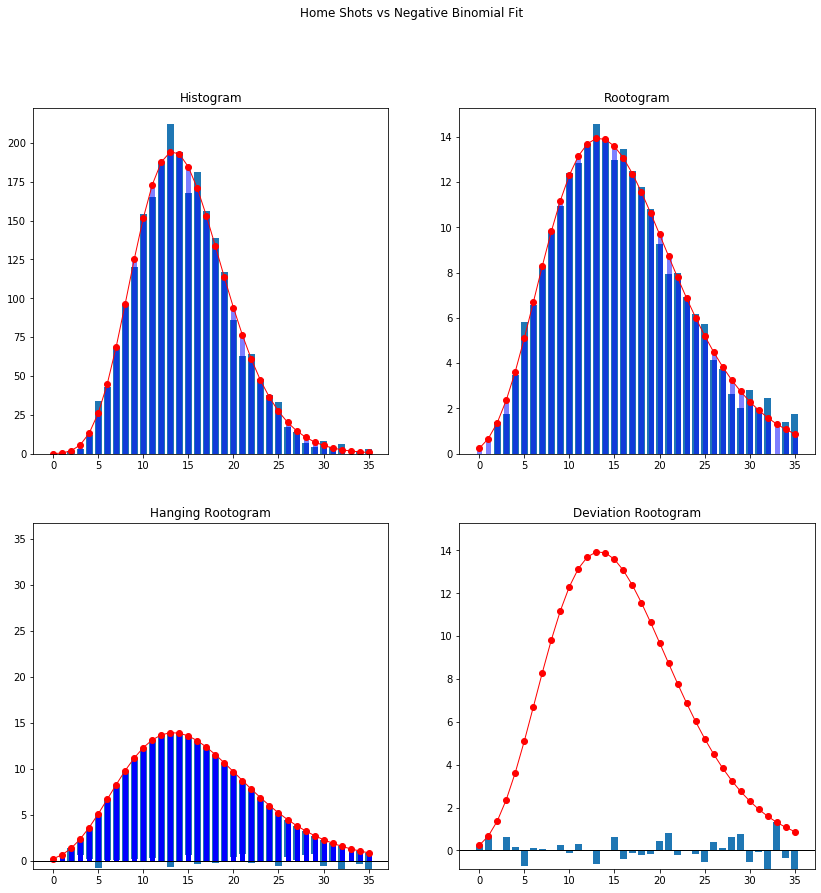

In [23]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_shots_nbinom.index,
                                  h_shots_nbinom['obs'],
                                  h_shots_nbinom['exp'])
plt.suptitle('Home Shots vs Negative Binomial Fit')

plt.show();